# 📌 1. Introdução (FINALIZAR)

O objetivo deste projeto é construir modelos preditivos para **detectar churn de clientes em uma empresa de telecomunicações**, utilizando uma base de dados do Kaggle. A tarefa é de **classificação binária**, e envolve o uso de diferentes algoritmos, como redes neurais (MLP e Transformer), Random Forest, Gradient Boosting e mais.

Este notebook está organizado em seções por **responsável** e segue princípios de **código limpo** com **funções reutilizáveis**, documentação clara e visualizações apropriadas.

O grupo é composto por:

- Brenda  Guerra (bvga)
- Yasmin Maria Wanderley Soares (ymws)
- Gabriel Ferreira da Silva (gfs4)
- Lucas Santiago Monterazo (lsm6)
- Matheus Correia (mcr)


# ⚙️ 2. Metodologia

## 2.1. Etapas do projeto
O projeto foi dividido para ser feito por etapas, com cada membro responsável por uma etapa:
- **T1-T4 (lsm6)**: Pré-processamento dos dados, normalização, codificação e divisão dos conjuntos
- **T5-T6 (Pessoa 2)**: Modelagem com MLP e Transformer
- **T7-T8 (Pessoa 3)**: Modelagem com Random Forest e Gradient Boosting
- **T9-T11 (Pessoa 4)**: Avaliação e visualização dos modelos
- **T12-T14 (Pessoa 5)**: Integração, documentação e apresentação



# 🧹 3. Pré-processamento



## 3.1. Carregamento e inspeção inicial

In [ ]:
#dependencias
import importlib.util

def check_and_install(package):
    if importlib.util.find_spec(package) is None:
        !pip install {package} -qq

check_and_install('tensorflow')
check_and_install('numpy')
check_and_install('pandas')
check_and_install('matplotlib')
check_and_install('scikit-learn')
check_and_install('kagglehub')
check_and_install('seaborn')


#libs
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import io
import os
import seaborn as sns
%matplotlib inline

In [ ]:
import kagglehub
import os
import pandas as pd

# Download do dataset pelo Kaggle
dataset_path = kagglehub.dataset_download("kapturovalexander/customers-churned-in-telecom-services")
csv_filename = 'customer_churn_telecom_services.csv' # Corrected filename
csv_filepath = os.path.join(dataset_path, csv_filename) # Construct the correct file path

#loading the dataset -- #decoding the files as uploaded will be a dictionary of keys (the file names) and values (the encoded file objects)

churn = pd.read_csv(csv_filepath)
display(churn.head())

100%|██████████| 112k/112k [00:00<00:00, 36.7MB/s]

Extracting files...


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 3.2. Limpeza dos dados (nulos, inconsistências, outliers)

In [ ]:
def tratar_dados(df):
    # Remove irrelevant columns if any (none identified in this dataset initially)
    # Handle 'TotalCharges' which is object type and contains some spaces
    # Replace spaces with NaN and then convert to numeric
    df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan)
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

    # Remove rows with missing values (introduced by the above step or originally present)
    df = df.dropna()

    # Handle inconsistencies in categorical strings (extra spaces, capitalization)
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].astype(str).str.strip().str.lower()

    return df

## 3.3. Codificação e normalização

- Codificação para redes (one-hot + normalização)

- Codificação para árvores (label ou nada)

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Identify categorical and numerical features
def get_feature_types(df, target='Churn'):
    categorical_features = df.select_dtypes(include='object').columns.tolist()
    if target in categorical_features:
        categorical_features.remove(target)
    numeric_features = df.select_dtypes(include=np.number).columns.tolist()
    return categorical_features, numeric_features

# Preprocessing for Neural Networks (One-Hot Encoding + Scaling)
def preprocess_for_nn(df, target='Churn'):
    df_processed = df.copy()
    categorical_features, numeric_features = get_feature_types(df_processed, target=target)

    # Separate target variable before processing
    y = df_processed[target].apply(lambda x: 1 if x == 'Yes' else 0) # Convert Churn to 0/1
    X = df_processed.drop(target, axis=1)


    # Create a column transformer for applying different transformations to different columns
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

    # Create a preprocessing pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

    X_processed = pipeline.fit_transform(X)
    return X_processed, y, pipeline # Return pipeline to be used for transforming new data

# Preprocessing for Tree-based Models (Label Encoding - for categorical features where order doesn't matter, or leave as is for some algorithms)
# For simplicity and compatibility with most tree models in sklearn, we'll use Label Encoding for object types.
def preprocess_for_trees(df, target='Churn'):
    df_processed = df.copy()
    # Convert target to numeric
    df_processed[target] = df_processed[target].apply(lambda x: 1 if x == 'Yes' else 0)

    for col in df_processed.select_dtypes(include='object').columns:
        df_processed[col] = LabelEncoder().fit_transform(df_processed[col])

    X = df_processed.drop(target, axis=1)
    y = df_processed[target]

    return X, y

## 3.4. Divisão dos dados (treino, validação, teste)

In [ ]:
from sklearn.model_selection import train_test_split

def dividir_dados(X, y):
    X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval)

    return X_train, X_val, X_test, y_train, y_val, y_test

## 3.5 Feature Engineering

In [ ]:
def create_engineered_features(df):
    df_engineered = df.copy()

    df_engineered['AvgMonthlyCharge_per_Tenure'] = df_engineered.apply(
        lambda row: row['TotalCharges'] / row['tenure'] if row['tenure'] > 0 else 0, axis=1
    )

    optional_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
    for col in optional_services:
        if col in df_engineered.columns:
            # Ensure consistent handling of 'No internet service' or similar
            df_engineered[col] = df_engineered[col].apply(lambda x: 1 if x == 'Yes' else 0)
    df_engineered['NumExtraServices'] = df_engineered[optional_services].sum(axis=1)

    if 'InternetService' in df_engineered.columns and 'Contract' in df_engineered.columns:
         df_engineered['InternetService_Contract'] = df_engineered['InternetService'] + '_' + df_engineered['Contract']

    if 'PaymentMethod' in df_engineered.columns:
        df_engineered['IsElectronicCheck'] = df_engineered['PaymentMethod'].apply(lambda x: 1 if x == 'Electronic check' else 0)

    return df_engineered

# Apply the feature engineering step to your cleaned data
# Make sure to run the 'tratar_dados' function first to get 'churn_cleaned'
churn_cleaned = tratar_dados(churn.copy())
churn_cleaned_engineered = create_engineered_features(churn_cleaned.copy())

print("Original columns:", churn_cleaned.columns.tolist())
print("Columns after feature engineering:", churn_cleaned_engineered.columns.tolist())
display(churn_cleaned_engineered[['tenure', 'MonthlyCharges', 'TotalCharges', 'AvgMonthlyCharge_per_Tenure', 'NumExtraServices', 'InternetService_Contract', 'IsElectronicCheck']].head())

Original columns: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']
Columns after feature engineering: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn', 'AvgMonthlyCharge_per_Tenure', 'NumExtraServices', 'InternetService_Contract', 'IsElectronicCheck']


,tenure,MonthlyCharges,TotalCharges,AvgMonthlyCharge_per_Tenure,NumExtraServices,InternetService_Contract,IsElectronicCheck
0,1,29.85,29.85,29.850000,0,dsl_month-to-month,0
1,34,56.95,1889.50,55.573529,0,dsl_one year,0
2,2,53.85,108.15,54.075000,0,dsl_month-to-month,0
3,45,42.30,1840.75,40.905556,0,dsl_one year,0
4,2,70.70,151.65,75.825000,0,fiber optic_month-to-month,0


## 3.6. Visualização inicial dos dados

In [ ]:
# Apply data cleaning
churn_cleaned = tratar_dados(churn.copy())

# Apply feature engineering
churn_engineered = create_engineered_features(churn_cleaned.copy())

# Preprocessing and Splitting for Neural Networks
X_processed_nn, y_nn, pipeline_nn = preprocess_for_nn(churn_engineered.copy())
X_train_nn, X_val_nn, X_test_nn, y_train_nn, y_val_nn, y_test_nn = dividir_dados(X_processed_nn, y_nn)

# Preprocessing and Splitting for Tree-based Models
X_processed_trees, y_trees = preprocess_for_trees(churn_engineered.copy())
X_train_trees, X_val_trees, X_test_trees, y_train_trees, y_val_trees, y_test_trees = dividir_dados(X_processed_trees, y_trees)

print("Data preprocessing and splitting complete.")
print("\nShapes for Neural Networks:")
print("X_train_nn:", X_train_nn.shape)
print("X_val_nn:", X_val_nn.shape)
print("X_test_nn:", X_test_nn.shape)
print("y_train_nn:", y_train_nn.shape)
print("y_val_nn:", y_val_nn.shape)
print("y_test_nn:", y_test_nn.shape)

print("\nShapes for Tree-based Models:")
print("X_train_trees:", X_train_trees.shape)
print("X_val_trees:", X_val_trees.shape)
print("X_test_trees:", X_test_trees.shape)
print("y_train_trees:", y_train_trees.shape)
print("y_val_trees:", y_val_trees.shape)
print("y_test_trees:", y_test_trees.shape)

Data preprocessing and splitting complete.

Shapes for Neural Networks:
X_train_nn: (4218, 45)
X_val_nn: (1407, 45)
X_test_nn: (1407, 45)
y_train_nn: (4218,)
y_val_nn: (1407,)
y_test_nn: (1407,)

Shapes for Tree-based Models:
X_train_trees: (4218, 23)
X_val_trees: (1407, 23)
X_test_trees: (1407, 23)
y_train_trees: (4218,)
y_val_trees: (1407,)
y_test_trees: (1407,)



--- Data after Cleaning ---
Shape before cleaning: (7043, 20)
Shape after cleaning: (7032, 20)

Missing values after cleaning:
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

--- Visualizing outliers after cleaning ---


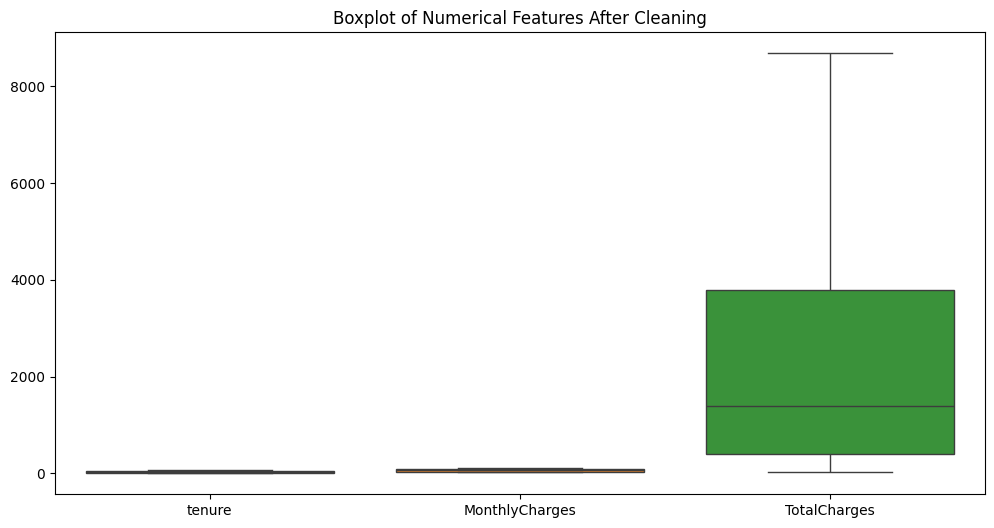


--- Data after Feature Engineering ---
Shape after Feature Engineering: (7032, 24)


,tenure,MonthlyCharges,TotalCharges,AvgMonthlyCharge_per_Tenure,NumExtraServices,InternetService_Contract,IsElectronicCheck
0,1,29.85,29.85,29.850000,0,dsl_month-to-month,0
1,34,56.95,1889.50,55.573529,0,dsl_one year,0
2,2,53.85,108.15,54.075000,0,dsl_month-to-month,0
3,45,42.30,1840.75,40.905556,0,dsl_one year,0
4,2,70.70,151.65,75.825000,0,fiber optic_month-to-month,0



--- Data after Encoding (for Neural Networks) ---
Shape after One-Hot Encoding and Scaling: (7032, 45)


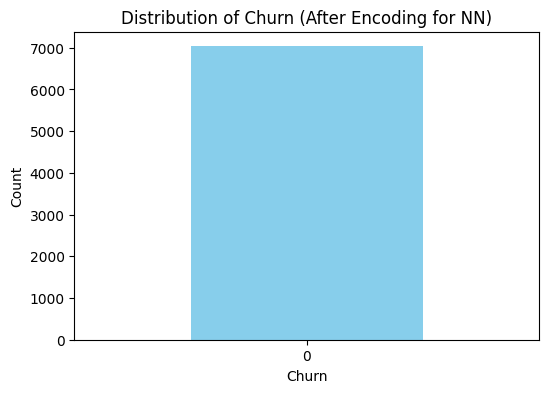


--- Data after Encoding (for Tree-based Models) ---
Shape after Label Encoding: (7032, 23)


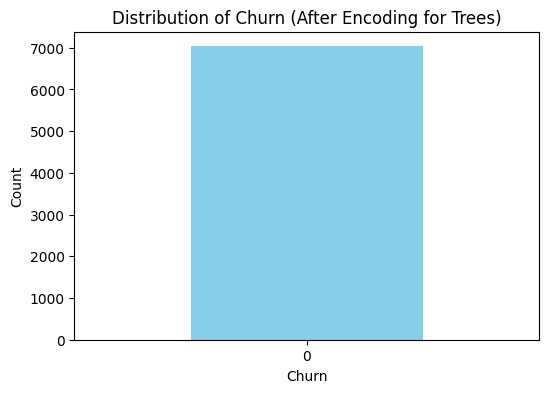


--- Data after Splitting (Example for Neural Networks) ---
Shape of X_train_nn: (4218, 45)
Shape of X_val_nn: (1407, 45)
Shape of X_test_nn: (1407, 45)
Shape of y_train_nn: (4218,)
Shape of y_val_nn: (1407,)
Shape of y_test_nn: (1407,)


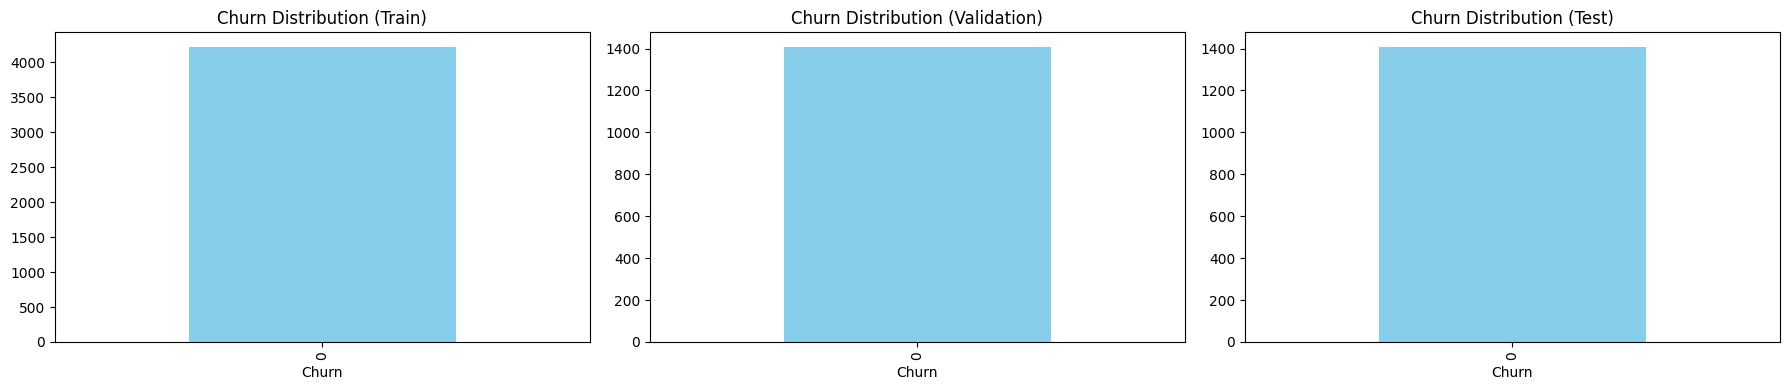

In [ ]:
print("\n--- Data after Cleaning ---")
print("Shape before cleaning:", churn.shape)
print("Shape after cleaning:", churn_cleaned.shape)
print("\nMissing values after cleaning:")
print(churn_cleaned.isnull().sum())

print("\n--- Visualizing outliers after cleaning ---")
plt.figure(figsize=(12, 6))
sns.boxplot(data=churn_cleaned[['tenure', 'MonthlyCharges', 'TotalCharges']])
plt.title('Boxplot of Numerical Features After Cleaning')
plt.show()


print("\n--- Data after Feature Engineering ---")
print("Shape after Feature Engineering:", churn_engineered.shape)
display(churn_engineered[['tenure', 'MonthlyCharges', 'TotalCharges', 'AvgMonthlyCharge_per_Tenure', 'NumExtraServices', 'InternetService_Contract', 'IsElectronicCheck']].head())


print("\n--- Data after Encoding (for Neural Networks) ---")
print("Shape after One-Hot Encoding and Scaling:", X_processed_nn.shape)
# Visualize the distribution of the target variable in the processed data.
plt.figure(figsize=(6, 4))
pd.Series(y_nn).value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Churn (After Encoding for NN)')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


print("\n--- Data after Encoding (for Tree-based Models) ---")
print("Shape after Label Encoding:", X_processed_trees.shape)
# Visualize the distribution of the target variable again.
plt.figure(figsize=(6, 4))
pd.Series(y_trees).value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Churn (After Encoding for Trees)')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


print("\n--- Data after Splitting (Example for Neural Networks) ---")
print("Shape of X_train_nn:", X_train_nn.shape)
print("Shape of X_val_nn:", X_val_nn.shape)
print("Shape of X_test_nn:", X_test_nn.shape)
print("Shape of y_train_nn:", y_train_nn.shape)
print("Shape of y_val_nn:", y_val_nn.shape)
print("Shape of y_test_nn:", y_test_nn.shape)

# Visualize the distribution of the target variable in each split to check stratification.
plt.figure(figsize=(18, 4))
plt.subplot(1, 3, 1)
pd.Series(y_train_nn).value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Churn Distribution (Train)')
plt.subplot(1, 3, 2)
pd.Series(y_val_nn).value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Churn Distribution (Validation)')
plt.subplot(1, 3, 3)
pd.Series(y_test_nn).value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Churn Distribution (Test)')
plt.tight_layout()
plt.show()

# 🧠 4. Modelagem com Redes Neurais (Pessoa 2)

# 🌲 5. Modelagem com Árvores (Pessoa 3)

# 📊 6. Avaliação (Pessoa 4)

## 6.1. Métricas de avaliação

In [ ]:
from sklearn.metrics import classification_report
from scipy.stats import ks_2samp

def avaliar_modelo(model, X, y):
    y_pred = model.predict(X)
    y_pred_prob = model.predict_proba(X)[:, 1]
    print(classification_report(y, y_pred))
    print("KS:", ks_2samp(y_pred_prob[y==0], y_pred_prob[y==1]).statistic)


## 6.2. Visualizações

- Matriz de confusão
- Curvas ROC e Precision-Recall
- Comparação de modelos em tabela

## 7.1. Organização dos notebooks
- Juntar notebooks por responsável
- Separar funções reutilizáveis em arquivo `.py`

## 7.2. Instruções de uso (README.md)
- Como executar o projeto
- Dependências (`requirements.txt`)
- Estrutura de diretórios

# 📎 9. Referências
- [Dataset do Kaggle](https://www.kaggle.com/datasets/kapturovalexander/customers-churned-in-telecom-services/data)
- Germano Vasconcelos (slides)
- Documentação do Scikit-Learn, Keras e XGBoost

## 3.6. Visualização e Análise dos Dados Após Cada Etapa de Pré-processamento

Nesta seção, visualizaremos os dados após cada etapa de pré-processamento para entender as transformações aplicadas e o impacto na estrutura dos dados.